# Goal: Identify the metrics that most significantly contribute to +/- in the NBA.

In [1]:
from nba_api.stats.endpoints import commonteamroster, playercareerstats, playergamelog, boxscoresummaryv2, teamdashlineups, boxscoreadvancedv2
from nba_api.stats.static import teams
from nba_api.stats.library.parameters import SeasonAll
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from requests.exceptions import ReadTimeout
import random

### Function: Get Roster

In [2]:
def get_team_roster(team_name: str, season: str):
    # Fetch all teams
    nba_teams = teams.get_teams()
    
    # Find the team ID for the given team name
    team = next((team for team in nba_teams if team['full_name'].lower() == team_name.lower()), None)
    if not team:
        print(f"Team '{team_name}' not found.")
        return None

    team_id = team['id']

    roster_data = commonteamroster.CommonTeamRoster(team_id=team_id, season=season)
    roster = roster_data.get_normalized_dict()

    roster_df = pd.DataFrame(roster['CommonTeamRoster'])
    
    return roster_df

### Function: Get Player Basic Logs

In [3]:
def get_player_basic_game_logs(player_id, season_type_all_star="Regular Season", season="2024-25"):
    player_games = playergamelog.PlayerGameLog(player_id=player_id, season_type_all_star=season_type_all_star,season=season)
    game_logs_df = player_games.get_data_frames()[0]    
    return game_logs_df

### Function: Get Player Advanced Stat Logs

In [4]:
def exponential_backoff_retry(func, *args, max_retries=5, initial_wait=1, multiplier=2, **kwargs):

    wait_time = initial_wait
    for attempt in range(max_retries):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Error: {e}. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
                wait_time *= multiplier
            else:
                raise e

In [5]:
def get_combined_player_stats(player_id, season, season_type="Regular Season"):
    basic_logs = exponential_backoff_retry(get_player_basic_game_logs, player_id, season_type, season)

    basic_logs = basic_logs.drop(columns=["VIDEO_AVAILABLE"], errors="ignore")

    advanced_columns = [
        "PLAYER_ID", "GAME_ID", "OFF_RATING", "E_OFF_RATING", "DEF_RATING", "E_DEF_RATING", 
        "NET_RATING", "E_NET_RATING", "AST_PCT", "AST_TOV", "AST_RATIO", "OREB_PCT", 
        "DREB_PCT", "REB_PCT", "TM_TOV_PCT", "EFG_PCT", "TS_PCT", "USG_PCT", 
        "E_USG_PCT", "E_PACE", "PACE", "PACE_PER40", "POSS", "PIE"
    ]
    advanced_stats_combined = pd.DataFrame()

    for game_id in basic_logs["Game_ID"].unique():
        retries = 5
        backoff = 1

        while retries > 0:
            try:
                advanced_stats = boxscoreadvancedv2.BoxScoreAdvancedV2(str(game_id)).get_data_frames()[0]

                filtered_advanced_stats = advanced_stats[advanced_columns]

                advanced_stats_combined = pd.concat([advanced_stats_combined, filtered_advanced_stats], ignore_index=True)
                break
            except ReadTimeout:
                print(f"Timeout error for GAME_ID {game_id}. Retrying in {backoff} seconds...")
                time.sleep(backoff)
                backoff *= 2
                retries -= 1
            except Exception as e:
                print(f"Error fetching advanced stats for GAME_ID {game_id}: {e}. Retrying in {backoff} seconds...")
                time.sleep(backoff)
                backoff *= 2
                retries -= 1

        if retries == 0:
            print(f"Failed to fetch data for GAME_ID {game_id} after multiple retries.")

        time.sleep(random.uniform(1, 3))

    basic_logs = basic_logs.rename(columns={"Player_ID": "PLAYER_ID", "Game_ID": "GAME_ID"})

    combined_stats = pd.merge(
        basic_logs, 
        advanced_stats_combined, 
        on=["PLAYER_ID", "GAME_ID"], 
        how="inner"
    )

    return combined_stats

In [6]:
def fetch_all_player_stats(roster, season="2024-25"):
    all_player_stats = pd.DataFrame()
    total_players = len(roster['PLAYER_ID'])

    print(f"Starting to gather stats for {total_players} players for the {season} season.")

    for idx, player_id in enumerate(roster['PLAYER_ID'], start=1):
        print(f"\n[{idx}/{total_players}] Gathering stats for player ID: {player_id}...")
        retries = 5
        backoff = 1

        while retries > 0:
            try:
                # Fetch combined player stats
                print(f"Attempting to fetch stats for player ID: {player_id} (Retries left: {retries})...")
                player_stats = get_combined_player_stats(player_id, season)
                print(f"Successfully fetched stats for player ID: {player_id}.")

                # Append player stats to the master DataFrame
                all_player_stats = pd.concat([all_player_stats, player_stats], ignore_index=True)
                break
            except ReadTimeout:
                print(f"Timeout error for player ID: {player_id}. Retrying in {backoff} seconds...")
                time.sleep(backoff)
                backoff *= 2
                retries -= 1
            except Exception as e:
                print(f"Critical error fetching stats for player ID: {player_id}: {e}")
                print("Skipping this player after encountering an error.")
                break

        if retries == 0:
            print(f"Failed to fetch stats for player ID: {player_id} after 5 retries. Moving to the next player.")

        delay = random.uniform(1, 3)
        print(f"Adding a delay of {delay:.2f} seconds before processing the next player.")
        time.sleep(delay)

    print("\nFinished gathering stats for all players.")
    return all_player_stats


# ----> Main <----

# Analysis of Golden State Warriors only

### Fetch Warriors Roster

In [22]:
warriors_roster = get_team_roster("Golden State Warriors", "2024-25")
warriors_roster = warriors_roster[['PLAYER','PLAYER_ID']]
warriors_roster.head()

,PLAYER,PLAYER_ID
0,Gary Payton II,1627780
1,Jonathan Kuminga,1630228
2,Kyle Anderson,203937
3,Brandin Podziemski,1641764
4,Moses Moody,1630541


### Create DataFrame for all player stats

In [23]:
all_player_stats = pd.DataFrame()

### Grab all player stats for the Warriors

In [24]:
'''
try:
    all_player_stats = fetch_all_player_stats(warriors_roster)
    print("All player stats gathered successfully.")
except Exception as e:
    print(f"Failed to fetch player stats: {e}")

# Save to file or further process
all_player_stats.to_csv("warriors_player_stats_2024_25.csv", index=False)
'''

'\ntry:\n    all_player_stats = fetch_all_player_stats(warriors_roster)\n    print("All player stats gathered successfully.")\nexcept Exception as e:\n    print(f"Failed to fetch player stats: {e}")\n\n# Save to file or further process\nall_player_stats.to_csv("warriors_player_stats_2024_25.csv", index=False)\n'

### Optional: Load data from CSV

In [63]:
all_player_stats = pd.read_csv("warriors_player_stats_2024_25.csv").drop(columns=["GAME_ID", "PLAYER_ID", "SEASON_ID", "E_NET_RATING", "E_DEF_RATING", "E_OFF_RATING"])
correlation_matrix = all_player_stats.select_dtypes(include=[float, int]).corr()
correlation_matrix.columns

Index(['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'OFF_RATING', 'DEF_RATING', 'NET_RATING',
       'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT',
       'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE',
       'PACE', 'PACE_PER40', 'POSS', 'PIE'],
      dtype='object')

In [64]:
plus_minus_corr = correlation_matrix["PLUS_MINUS"].sort_values(key=abs, ascending=False)
significant_corr = plus_minus_corr[abs(plus_minus_corr) >= 0.1]

In [14]:
exclude_cols = [
     "NET_RATING", "E_NET_RATING",
    "DEF_RATING", "E_DEF_RATING", "OFF_RATING", "E_OFF_RATING", "PLAYER_ID"
]
# NOTE: Debatably PIE should be in here, just add it to this list if you want to not show it on second charts

In [66]:
heatmap_full = correlation_matrix[["PLUS_MINUS"]].drop(index=["PLUS_MINUS"], errors="ignore")
heatmap_filtered = heatmap_full.drop(index=exclude_cols, errors="ignore")

### Heat Maps for all stats and non-rating stats

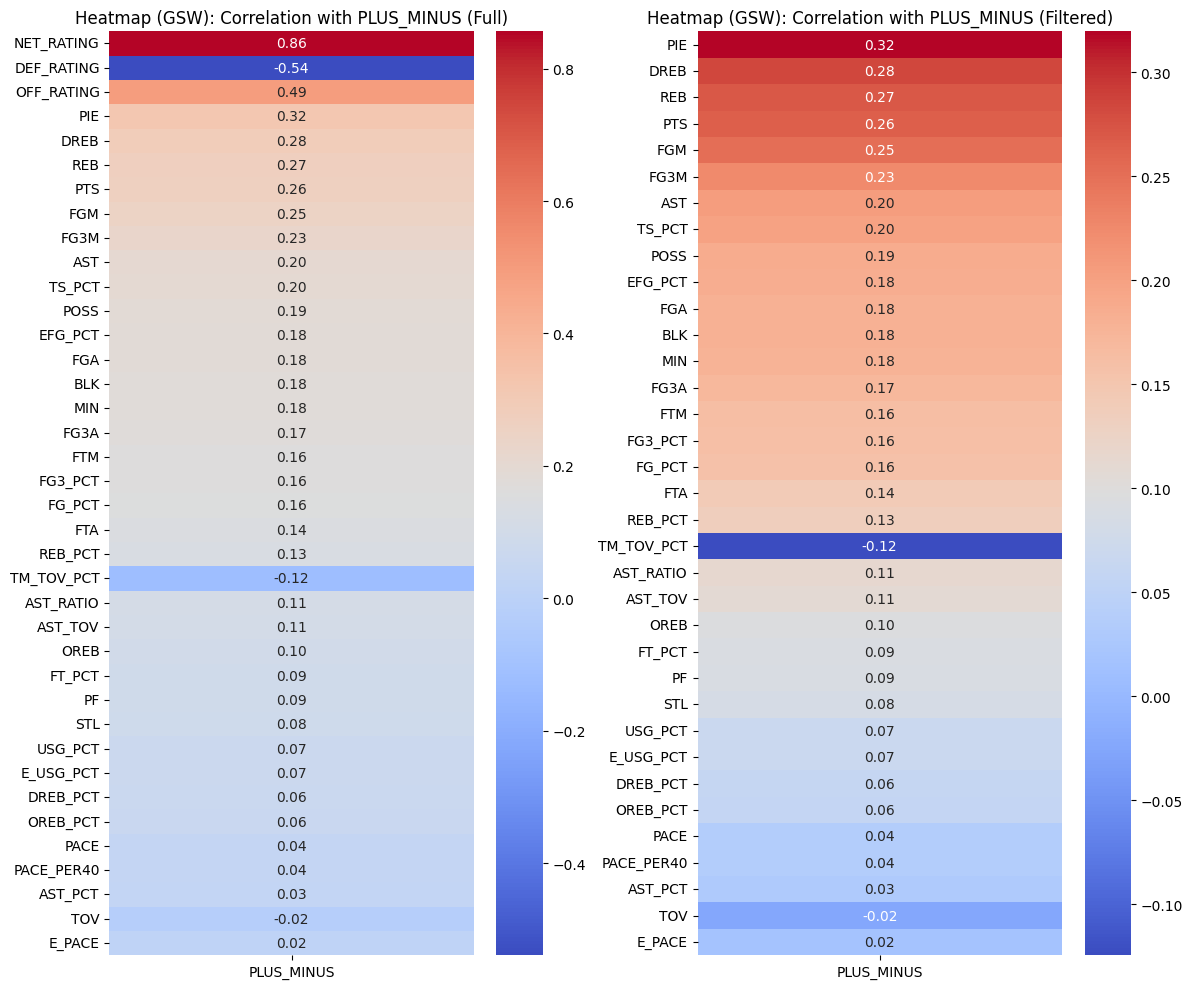

In [75]:
heatmap_full_sorted = heatmap_full.reindex(
    heatmap_full["PLUS_MINUS"].abs().sort_values(ascending=False).index
)

heatmap_filtered_sorted = heatmap_filtered.reindex(
    heatmap_filtered["PLUS_MINUS"].abs().sort_values(ascending=False).index
)

fig, axes = plt.subplots(1, 2, figsize=(12, 10))

sns.heatmap(heatmap_full_sorted, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0], cbar=True)
axes[0].set_title("Heatmap (GSW): Correlation with PLUS_MINUS (Full)")

sns.heatmap(heatmap_filtered_sorted, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1], cbar=True)
axes[1].set_title("Heatmap (GSW): Correlation with PLUS_MINUS (Filtered)")

plt.tight_layout()
plt.show()

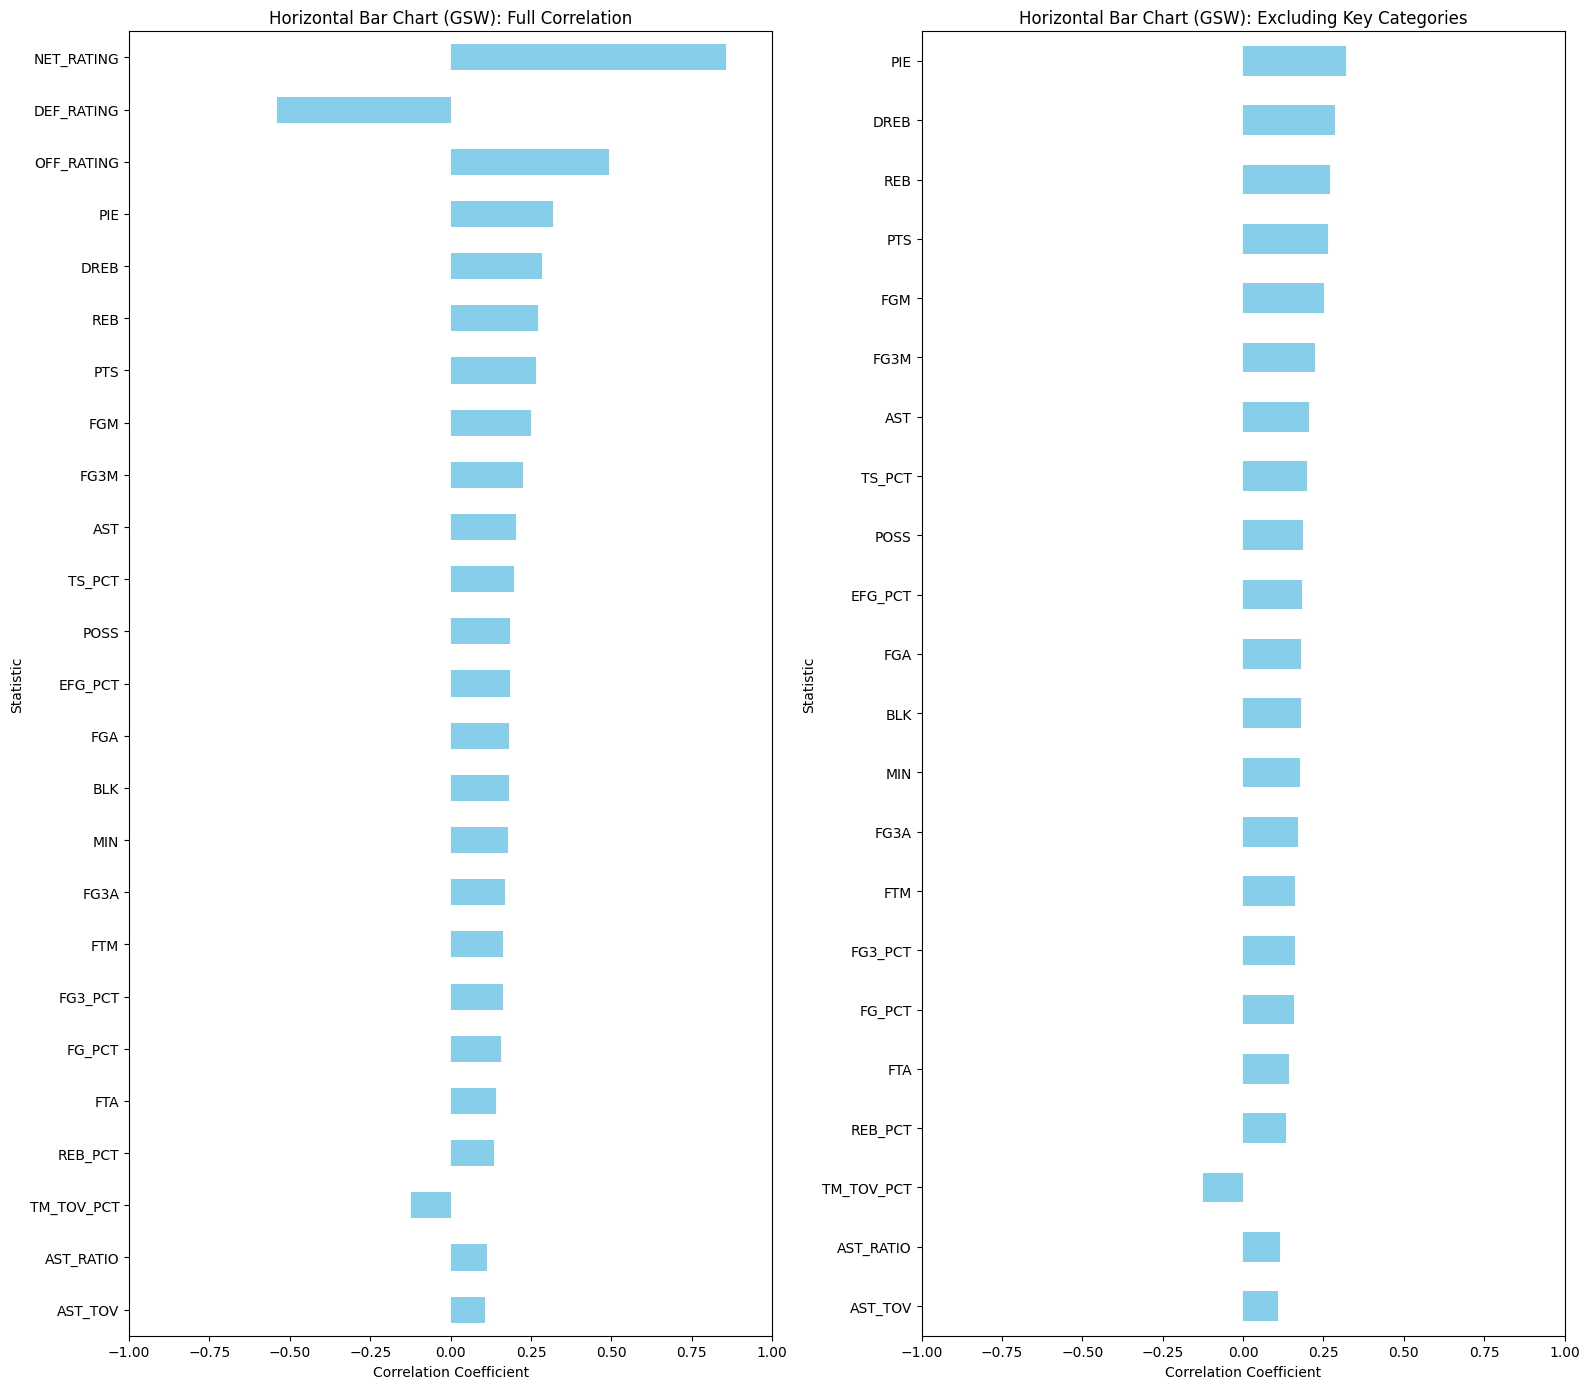

In [76]:

correlations_full = significant_corr.drop("PLUS_MINUS")
correlations_filtered = correlations_full.drop(exclude_cols, errors="ignore")


fig, axes = plt.subplots(1, 2, figsize=(16, 14))
correlations_full.sort_values(key=abs).plot(kind="barh", color="skyblue", ax=axes[0])
axes[0].set_title("Horizontal Bar Chart (GSW): Full Correlation")
axes[0].set_xlabel("Correlation Coefficient")
axes[0].set_ylabel("Statistic")
axes[0].set_xlim(-1,1)

correlations_filtered.sort_values(key=abs).plot(kind="barh", color="skyblue", ax=axes[1])
axes[1].set_title("Horizontal Bar Chart (GSW): Excluding Key Categories")
axes[1].set_xlabel("Correlation Coefficient")
axes[1].set_ylabel("Statistic")
axes[1].set_xlim(-1,1)

plt.tight_layout()
plt.show()

# Same Process for All NBA Teams

In [77]:
nba_teams = teams.get_teams()

In [84]:
for idx, team in nba_teams:
    team['full_name']

Atlanta Hawks
Boston Celtics
Cleveland Cavaliers
New Orleans Pelicans
Chicago Bulls
Dallas Mavericks
Denver Nuggets
Golden State Warriors
Houston Rockets
Los Angeles Clippers
Los Angeles Lakers
Miami Heat
Milwaukee Bucks
Minnesota Timberwolves
Brooklyn Nets
New York Knicks
Orlando Magic
Indiana Pacers
Philadelphia 76ers
Phoenix Suns
Portland Trail Blazers
Sacramento Kings
San Antonio Spurs
Oklahoma City Thunder
Toronto Raptors
Utah Jazz
Memphis Grizzlies
Washington Wizards
Detroit Pistons
Charlotte Hornets


In [7]:
def fetch_league_stats(season="2024-25"):
    # Fetch all NBA teams
    nba_teams = teams.get_teams()
    
    league_stats = pd.DataFrame()

    print(f"Starting to gather stats for all NBA teams for the {season} season.\n")

    for idx, team in enumerate(nba_teams, start=1):
        team_name = team['full_name']
        team_id = team['id']

        print(f"[{idx}/{len(nba_teams)}] Processing team: {team_name} (Team ID: {team_id})")

        try:
            # Fetch the team's roster
            roster_df = get_team_roster(team_name, season)

            if roster_df is None or roster_df.empty:
                print(f"No roster data available for {team_name}. Skipping.")
                continue

            # Fetch player stats for the team
            print(f"Fetching stats for players in {team_name}...")
            team_stats = fetch_all_player_stats(roster_df, season=season)

            # Append team stats to the league-wide DataFrame
            league_stats = pd.concat([league_stats, team_stats], ignore_index=True)

        except Exception as e:
            print(f"Error processing team {team_name}: {e}. Skipping to the next team.")

        # Add a random delay to avoid hitting API rate limits
        delay = random.uniform(2, 5)
        print(f"Adding a delay of {delay:.2f} seconds before processing the next team.\n")
        time.sleep(delay)

    print("\nFinished gathering stats for all teams.")
    return league_stats

In [8]:
league_stats = fetch_league_stats()

Starting to gather stats for all NBA teams for the 2024-25 season.

[1/30] Processing team: Atlanta Hawks (Team ID: 1610612737)
Fetching stats for players in Atlanta Hawks...
Starting to gather stats for 17 players for the 2024-25 season.

[1/17] Gathering stats for player ID: 1630552...
Attempting to fetch stats for player ID: 1630552 (Retries left: 5)...
Successfully fetched stats for player ID: 1630552.
Adding a delay of 1.82 seconds before processing the next player.

[2/17] Gathering stats for player ID: 1630811...
Attempting to fetch stats for player ID: 1630811 (Retries left: 5)...
Successfully fetched stats for player ID: 1630811.
Adding a delay of 1.48 seconds before processing the next player.

[3/17] Gathering stats for player ID: 1641723...
Attempting to fetch stats for player ID: 1641723 (Retries left: 5)...
Successfully fetched stats for player ID: 1641723.
Adding a delay of 1.62 seconds before processing the next player.

[4/17] Gathering stats for player ID: 1630700...


In [9]:
# league_stats.to_csv("entire_nba_player_stats_2024_25.csv", index=False)

In [10]:
league_stats = pd.read_csv("entire_nba_player_stats_2024_25.csv").drop(columns=["GAME_ID", "PLAYER_ID", "SEASON_ID", "E_NET_RATING", "E_DEF_RATING", "E_OFF_RATING"])

In [11]:
correlation_matrix = league_stats.select_dtypes(include=[float, int]).corr()
correlation_matrix.columns

Index(['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'OFF_RATING', 'DEF_RATING', 'NET_RATING',
       'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT',
       'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE',
       'PACE', 'PACE_PER40', 'POSS', 'PIE'],
      dtype='object')

In [12]:
plus_minus_corr = correlation_matrix["PLUS_MINUS"].sort_values(key=abs, ascending=False)
significant_corr = plus_minus_corr[abs(plus_minus_corr) >= 0.1]

In [15]:
heatmap_full = correlation_matrix[["PLUS_MINUS"]].drop(index=["PLUS_MINUS"], errors="ignore")
heatmap_filtered = heatmap_full.drop(index=exclude_cols, errors="ignore")

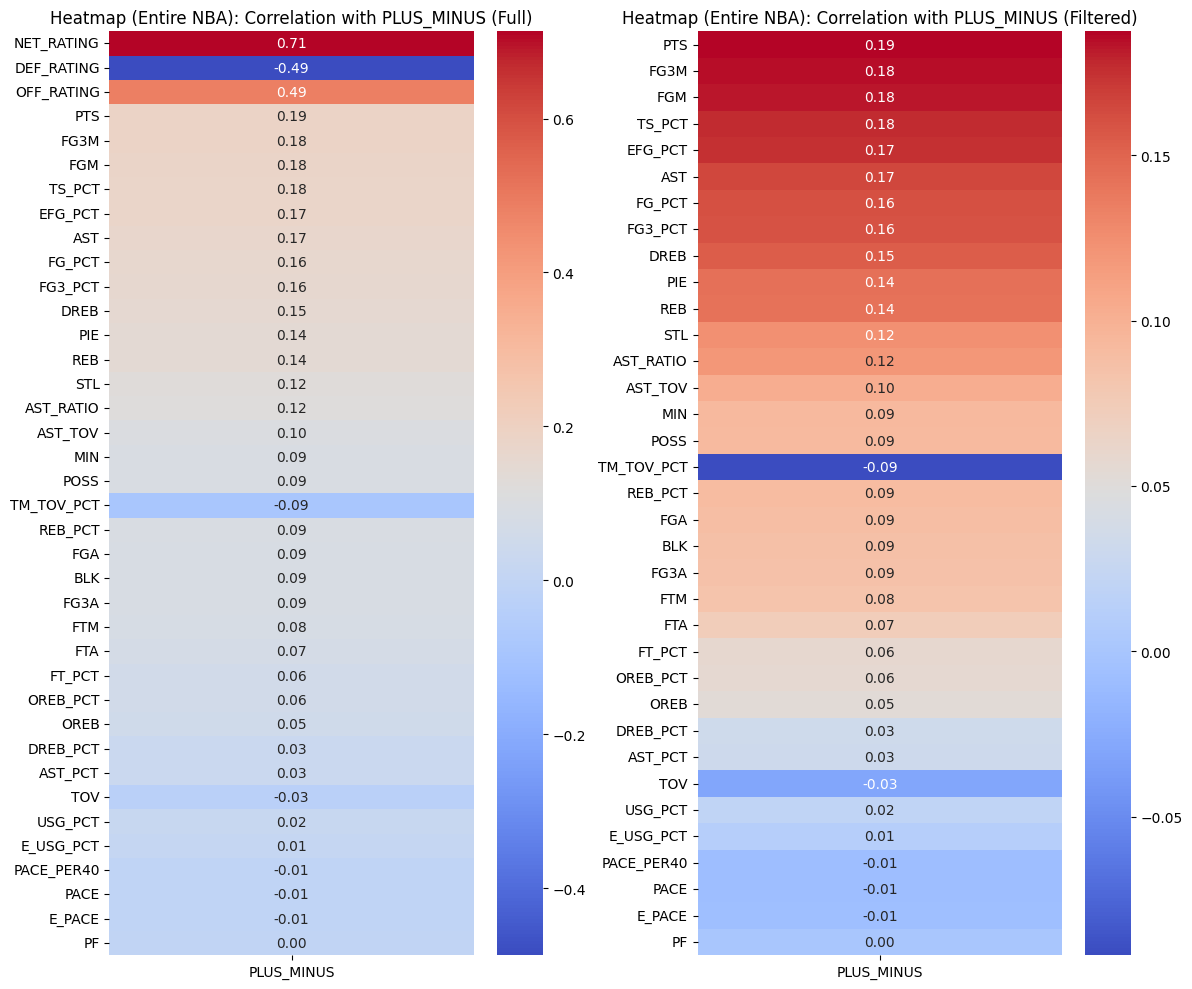

In [17]:
heatmap_full_sorted = heatmap_full.reindex(
    heatmap_full["PLUS_MINUS"].abs().sort_values(ascending=False).index
)

heatmap_filtered_sorted = heatmap_filtered.reindex(
    heatmap_filtered["PLUS_MINUS"].abs().sort_values(ascending=False).index
)

fig, axes = plt.subplots(1, 2, figsize=(12, 10))

sns.heatmap(heatmap_full_sorted, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0], cbar=True)
axes[0].set_title("Heatmap (Entire NBA): Correlation with PLUS_MINUS (Full)")

sns.heatmap(heatmap_filtered_sorted, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1], cbar=True)
axes[1].set_title("Heatmap (Entire NBA): Correlation with PLUS_MINUS (Filtered)")

plt.tight_layout()
plt.show()

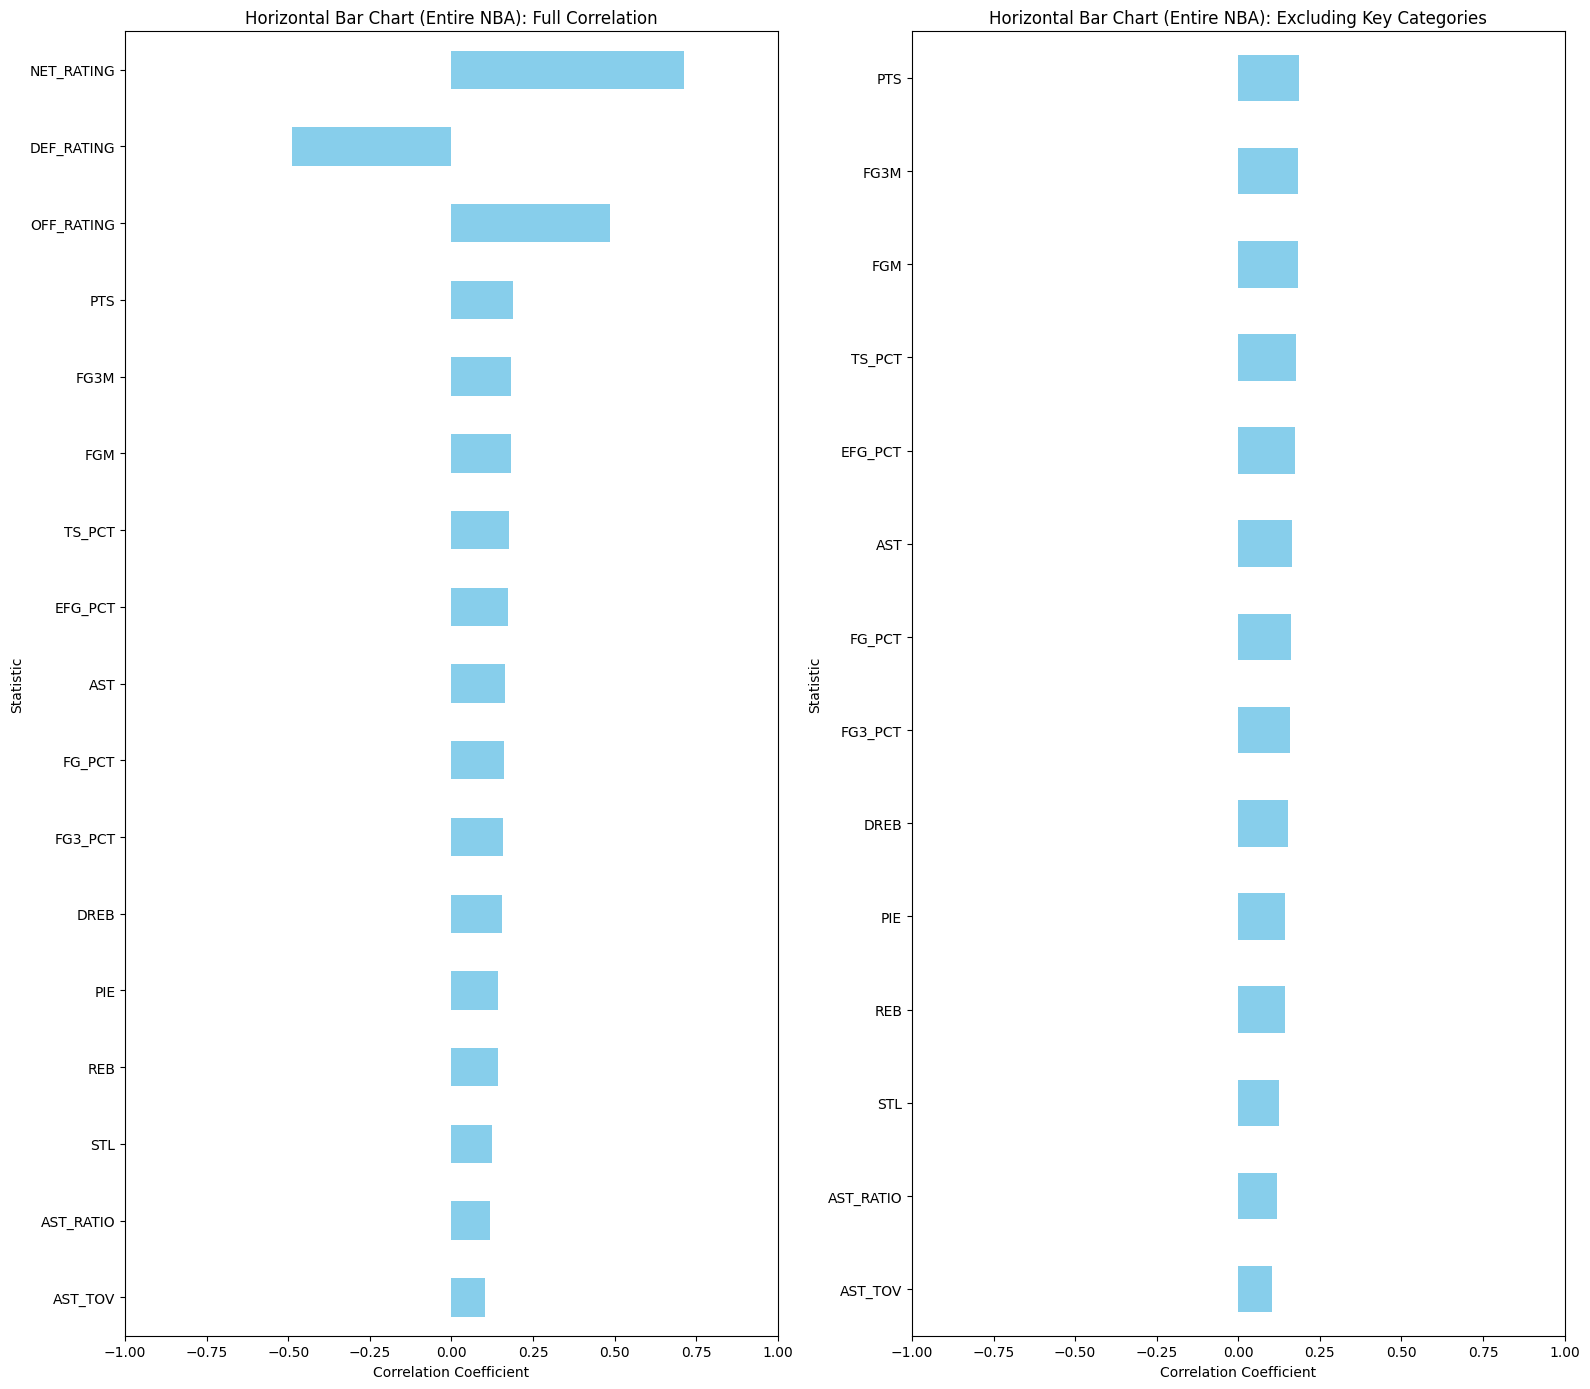

In [19]:

correlations_full = significant_corr.drop("PLUS_MINUS")
correlations_filtered = correlations_full.drop(exclude_cols, errors="ignore")


fig, axes = plt.subplots(1, 2, figsize=(16, 14))
correlations_full.sort_values(key=abs).plot(kind="barh", color="skyblue", ax=axes[0])
axes[0].set_title("Horizontal Bar Chart (Entire NBA): Full Correlation")
axes[0].set_xlabel("Correlation Coefficient")
axes[0].set_ylabel("Statistic")
axes[0].set_xlim(-1,1)

correlations_filtered.sort_values(key=abs).plot(kind="barh", color="skyblue", ax=axes[1])
axes[1].set_title("Horizontal Bar Chart (Entire NBA): Excluding Key Categories")
axes[1].set_xlabel("Correlation Coefficient")
axes[1].set_ylabel("Statistic")
axes[1].set_xlim(-1,1)

plt.tight_layout()
plt.show()

# Takeaways for GSW:
+ NET_RATING has the highest correlation with PLUS_MINUS (0.86): Reflects the direct impact of overall efficiency on the court for GSW.
+ DEF_RATING (-0.54) is more impactful than OFF_RATING (0.49): Highlights the Warriors’ reliance on defensive stops to create offensive opportunities and drive momentum.
+ PIE (0.32) plays a significant role: Captures the Warriors' need for holistic player contributions (e.g., defense, passing, and rebounding) rather than just scoring.
+ Rebounding is moderately important: Metrics like REB (0.27) and DREB (0.28) show the importance of securing possessions to sustain GSW's offensive runs.
+ Turnover metrics have minimal impact: TM_TOV_PCT (-0.12) and TOV (0.02) indicate that GSW’s high-risk, high-reward offensive style mitigates the negative effects of turnovers.


# Takeaways for entire NBA
+ NET_RATING has the highest correlation with PLUS_MINUS (0.86): Reflects the direct impact of overall efficiency on the court for GSW.
+ DEF_RATING (-0.54) is more impactful than OFF_RATING (0.49): Highlights the Warriors’ reliance on defensive stops to create offensive opportunities and drive momentum.
+ PIE (0.32) plays a significant role: Captures the Warriors' need for holistic player contributions (e.g., defense, passing, and rebounding) rather than just scoring.
+ Rebounding is moderately important: Metrics like REB (0.27) and DREB (0.28) show the importance of securing possessions to sustain GSW's offensive runs.
+ Turnover metrics have minimal impact: TM_TOV_PCT (-0.12) and TOV (0.02) indicate that GSW’s high-risk, high-reward offensive style mitigates the negative effects of turnovers.